In [1]:
import matplotlib.pyplot as plt
from pycqed import *

# Sub Circuits Example

In this notebook we show how to analyse more complex circuits that involve more than one qubit and coupler elements.

## Full Circuit Simulation

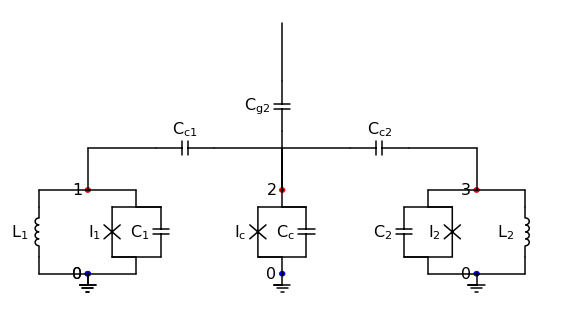

In [2]:
# Create the circuit
circuit = CircuitSpec("Averin Coupler with Flux Qubits")
circuit.addBranch(["L1"],"up",0,False,arm_len=0.5)
circuit.addBranch(["I1","C1"],"down",1,True,arm_len=0.5)
circuit.addBranch(["Cc1"],"right",1,False,lead_len=2,arm_len=0.5)
circuit.addBranch(["Cc2"],"right",2,False,lead_len=2,arm_len=0.5)
circuit.addChargeBias('up',2,lead_len=2)
circuit.addBranch(["Cc","Ic"],"down",2,True)
circuit.addBranch(["L2"],"down",3,True,arm_len=0.5)
circuit.addBranch(["I2","C2"],"up",0,False,arm_len=0.5)
circuit.drawCircuit(inline=True)

In [3]:
hamil_full = HamilSpec(circuit)
hamil_full.setTruncation(1,10,"charge")
hamil_full.setTruncation(2,4,"charge")
hamil_full.setTruncation(3,10,"charge")
hamil_full.prepareOperators()
hamil_full.getHilbertSpaceSize()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


3969

In [4]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj=0.2**1.2
Ajc=0.15*0.1
hamil_full.setParameterValues(
    'C1',Ca*Aj,
    'C2',Ca*Aj,
    'Cc1',1.0,
    'Cc2',1.0,
    'Cg2',1.0,
    'Cc',1.0,
    'I1',Jc*Aj,
    'I2',Jc*Aj,
    'Ic',Jc*Ajc,
    'L1',1000.0,
    'L2',1000.0,
    'phi10e',0.5,
    'phi03e',0.5,
    'Q2e',0.5
)

In [5]:
hamil_full.setParameterValue('phi10e', 0.5)
hamil_full.substitute({})
H = hamil_full.getHamiltonian()
print ("Hamiltonian Sparsity: %f" % hamil_full.sparsity(H))

Hamiltonian Sparsity: 0.989222


In [6]:
# At half-flux
H.eigenenergies()[0]

410.95106991799224

In [7]:
# At zero-flux, where we expect to find the other extremum
hamil_full.setParameterValues('phi10e',0.0)
hamil_full.substitute({})
H = hamil_full.getHamiltonian()
H.eigenenergies()[0]

24.30716513566267

In [8]:
# Configure diagonalizer
opts = {"sigma":23,"mode":"normal","maxiter":None,"tol":0}
hamil_full.setDiagConfig(sparse=True, sparsesolveropts=opts)

In [9]:
spec = [
    hamil_full.sweepSpec('phi10e',0.49,0.51,101)
]

sweep_full2 = hamil_full.paramSweep(spec,timesweep=True)

Parameter Sweep Duration:
  Initialization:	1.425 s
  Loop duration:	866.418 s
  Avg iteration:	8.578 s


Text(0, 0.5, '$E_{g,0}$ (GHz)')

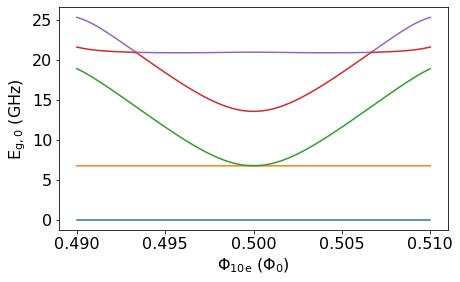

In [10]:
x,E,v = hamil_full.getSweep(sweep_full2,'phi10e',{})
for i in range(5):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,0}$ (GHz)")

## Reduced Circuit Simulation

In [11]:
sub_circuits = {
    "qb1":[(0,1),(1,0)],
    "qb2":[(0,3),(3,0)],
    "cpl":[(2,0)]
}
circuit.hierarchize(sub_circuits)

In [12]:
hamil = HierarchicalHamilSpec(circuit)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.
Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.
Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.
Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


In [13]:
hamil.setParameterValues(
    'C1',Ca*Aj,
    'C2',Ca*Aj,
    'Cc1',1.0,
    'Cc2',1.0,
    'Cg2',1.0,
    'Cc',1.0,
    'I1',Jc*Aj,
    'I2',Jc*Aj,
    'Ic',Jc*Ajc,
    'L1',1000.0,
    'L2',1000.0,
    'phi10e',0.5,
    'phi03e',0.5,
    'Q2e',0.5
)

In [14]:
hqb1 = hamil.getSubCircuit('qb1')
hqb1.setTruncation(1,10,"charge")
hqb1.prepareOperators()

hqb2 = hamil.getSubCircuit('qb2')
hqb2.setTruncation(3,10,"charge")
hqb2.prepareOperators()

hcpl = hamil.getSubCircuit('cpl')
hcpl.setTruncation(2,4,"charge")
hcpl.prepareOperators()

In [15]:
spec = [
    hqb1.sweepSpec('phi10e',0.49,0.51,101)
]
sweep = hqb1.paramSweep(spec)

Text(0, 0.5, '$E_{g,0}$ (GHz)')

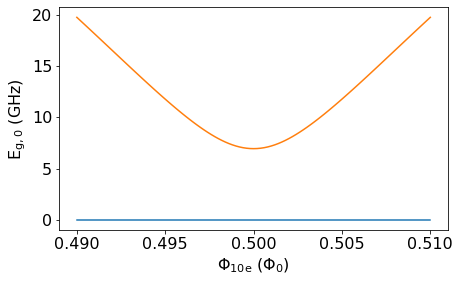

In [16]:
x,E,v = hqb1.getSweep(sweep,'phi10e',{})
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,0}$ (GHz)")

In [17]:
spec = [
    hcpl.sweepSpec('Q2e',0.0,1.0,101)
]
sweep = hcpl.paramSweep(spec)

Text(0, 0.5, '$E_{g,0}$ (GHz)')

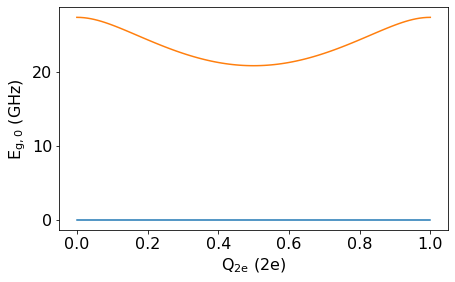

In [18]:
x,E,v = hcpl.getSweep(sweep,'Q2e',{})
for i in range(2):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$Q_{2e}$ ($2e$)")
plt.ylabel("$E_{g,0}$ (GHz)")

In [19]:
hamil.setSubCircuitTruncation('qb1', 8)
hamil.setSubCircuitTruncation('qb2', 8)
hamil.setSubCircuitTruncation('cpl', 5)
hamil.prepareOperators()

In [20]:
spec = [
    hamil.sweepSpec('phi10e',0.49,0.51,101)
]

sweep_red = hamil.paramSweep(spec,timesweep=True)

Parameter Sweep Duration:
  Initialization:	4.329 s
  Loop duration:	21.736 s
  Avg iteration:	0.215 s


Text(0, 0.5, '$E_{g,0}$ (GHz)')

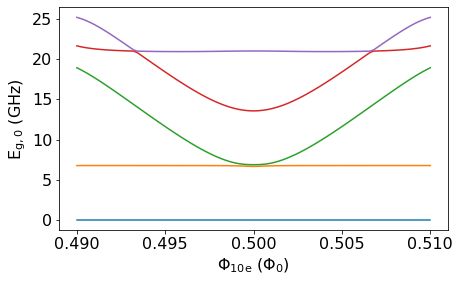

In [21]:
x,E,v = hamil.getSweep(sweep_red,'phi10e',{})
for i in range(5):
    plt.plot(x,E[i]-E[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,0}$ (GHz)")

Text(0, 0.5, '$E_{g,0}$ (GHz)')

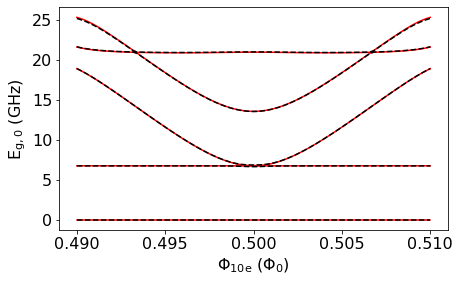

In [27]:
x,E,v = hamil_full.getSweep(sweep_full2,'phi10e',{})
x,Er,v = hamil.getSweep(sweep_red,'phi10e',{})
for i in range(5):
    plt.plot(x,E[i]-E[0],"r-")
for i in range(5):
    plt.plot(x,Er[i]-Er[0],"k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,0}$ (GHz)")

(6.5, 7)

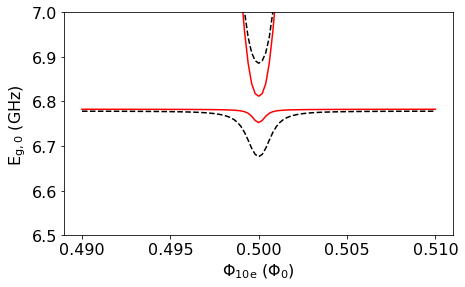

In [29]:
x,E,v = hamil_full.getSweep(sweep_full2,'phi10e',{})
x,Er,v = hamil.getSweep(sweep_red,'phi10e',{})
for i in range(5):
    plt.plot(x,E[i]-E[0],"r-")
for i in range(5):
    plt.plot(x,Er[i]-Er[0],"k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,0}$ (GHz)")
plt.ylim((6.5,7))